 # Discussion 11A, Fall 2021
 ## Helper Notebook for SVD Calculations & Geometric intuitions


In [1]:
import numpy as np
from math import cos, sin, pi, sqrt
import matplotlib
matplotlib.use('agg')
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from scipy.cluster.vq import vq, kmeans, whiten

from matplotlib.animation import FuncAnimation
from matplotlib.widgets import Slider

%matplotlib widget

# seed the pseudo random number generator with 0 
# so that the results are consistent in all discussion sections
np.random.seed(0)

import IPython
from ipywidgets import interactive, widgets
from IPython.display import display, HTML

## Question 1  ; Geometric intuitions for SVD

The following code helps visualize how different components of the SVD, namely U, $\Sigma$ (E here) and $V^\top$ act on 2D and 3D spaces.

In [2]:
class LinearTransform():
    """
    Apply linear transformation for given dimensions.
    
    Args:
        input_dims : #dims for space we're visualizing. Supports [2, 3]
    """
    
    def __init__(self, input_dims=2, num_points=40):
        self.input_dims = input_dims
        self.num_points = num_points
        self.plotter = self._get_plotter()
        self.points = self._gen_points()
        
    def _gen_points(self):
        if self.input_dims == 2:
            points = self._gen_unit_circle()
        elif self.input_dims == 3:
            points = self._gen_unit_sphere()
        return points
            
    def _gen_unit_circle(self):
        theta = np.linspace(0, 2*np.pi, self.num_points)
        x = np.cos(theta)
        y = np.sin(theta)
        return np.concatenate([[x], [y]], axis=0)
    
    def _gen_unit_sphere(self):
        phi, theta = np.meshgrid(np.linspace(0, 2*np.pi, self.num_points), np.linspace(0, 2*np.pi, self.num_points))
        x = np.cos(phi) * np.sin(theta)
        y = np.sin(phi) * np.sin(theta)
        z = np.cos(theta)
        return np.concatenate([[x], [y], [z]], axis=0)

    def _clear_plot(self):
        fig = plt.figure(figsize=(10, 10))
        if self.input_dims == 2:
            self.ax = fig.add_subplot(111)
        else:
            self.ax = fig.add_subplot(111, projection='3d')

    def _get_plotter(self):
        if self.input_dims == 2:
            return self.plot2d
        elif self.input_dims == 3:
            return self.plot3d

    def plot2d(self, points, axlim=None, label='circle'):
        pplot = self.ax.plot(points[0], points[1], label=label)
        maxval = np.max(np.abs(points))
        if axlim is None:
            axlim = maxval
        self.ax.set_xlim(-axlim, axlim)
        self.ax.set_ylim(-axlim, axlim)
        self.ax.grid()

    def plot3d(self, points, axlim=None, label='sphere'):
        pplot = self.ax.plot_surface(points[0], points[1], points[2],  cmap='autumn', alpha=0.25, label=label)
        pplot._facecolors2d=pplot._facecolor3d
        pplot._edgecolors2d=pplot._edgecolor3d
        maxval = np.max(np.abs(points))
        if axlim is None:
            axlim = maxval
        self.ax.set_xlim(-axlim, axlim)
        self.ax.set_ylim(-axlim, axlim)
        self.ax.set_zlim(-axlim, axlim)
        self.ax.set_xlabel('$x$', fontsize=30, rotation = 0)
        self.ax.set_ylabel('$y$', fontsize=30, rotation = 0)
        self.ax.set_zlabel('$z$', fontsize=30, rotation = 0)
    
    def __call__(self, A=None, with_basis=True, label='circle', axlim=3):
        if A is None:
            A = np.eye(self.input_dims)
        points = self.points.reshape(self.input_dims, -1)
        transformed_points = A @ points
        points = transformed_points.reshape(self.points.shape)
        self.plot(points, axlim=axlim, label=label)
        
        if with_basis:
            basis = self.get_basis_vectors()
            transformed_basis = A @ basis
            self.plot_vectors(transformed_basis.T)
        plt.legend()
    
    def plot(self, points=None, axlim=None, label='circle', clear=True):
        if clear:
            self._clear_plot()
        if points is None:
            points = self.points
        self.plotter(points, axlim=axlim, label=label)
        # return self.ax
        
    def get_basis_vectors(self):
        eye = np.eye(self.input_dims)
        return eye[:self.input_dims]
    
    def plot_vectors(self, vectors, prefix="e"):
        colors = plt.cm.get_cmap('winter', self.input_dims)
        for idx, vec in enumerate(vectors):
            points = np.concatenate([[vec], [np.zeros(self.input_dims)]], axis=0).T
            self.ax.plot(*points, color=colors(idx), label=r"${}_{}$".format(prefix, idx+1), linewidth=3)
        plt.legend()
            

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
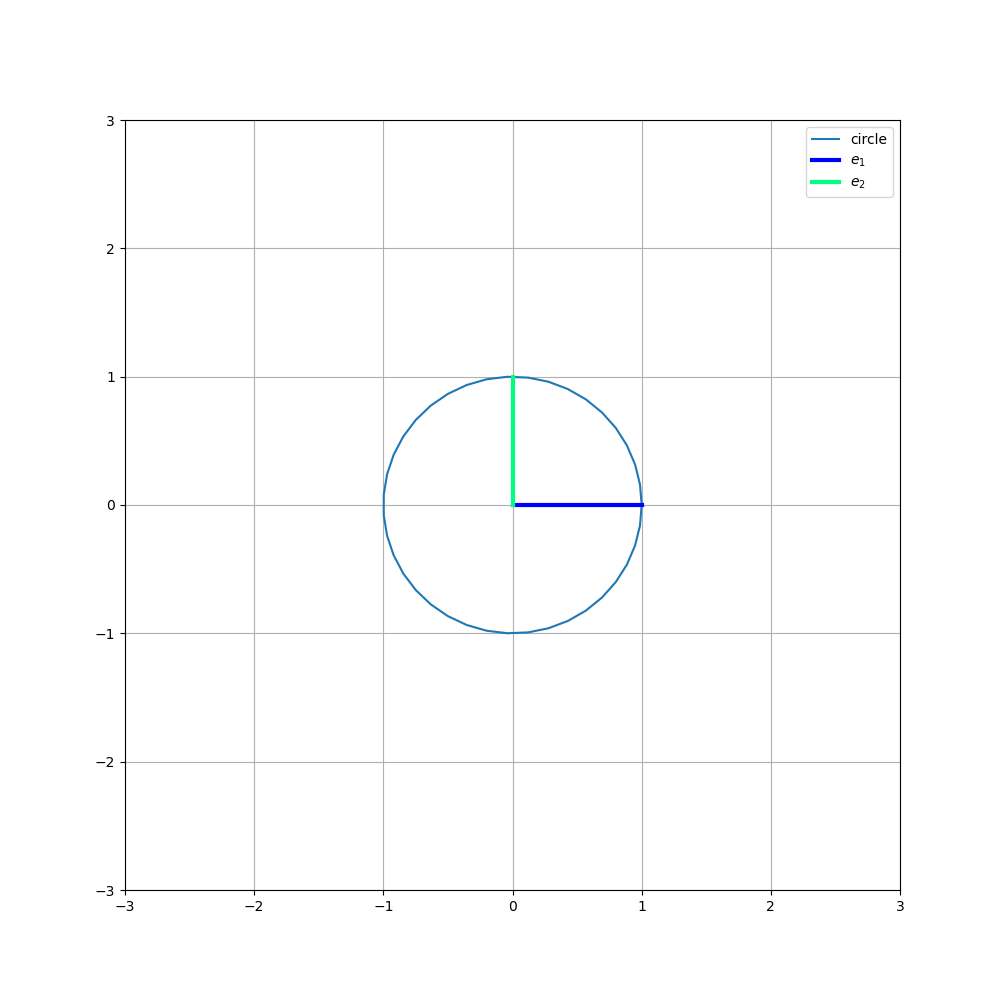

In [3]:
# change the input_dims to 3 for 3D projections
transform = LinearTransform(input_dims=2)
transform(label="circle")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
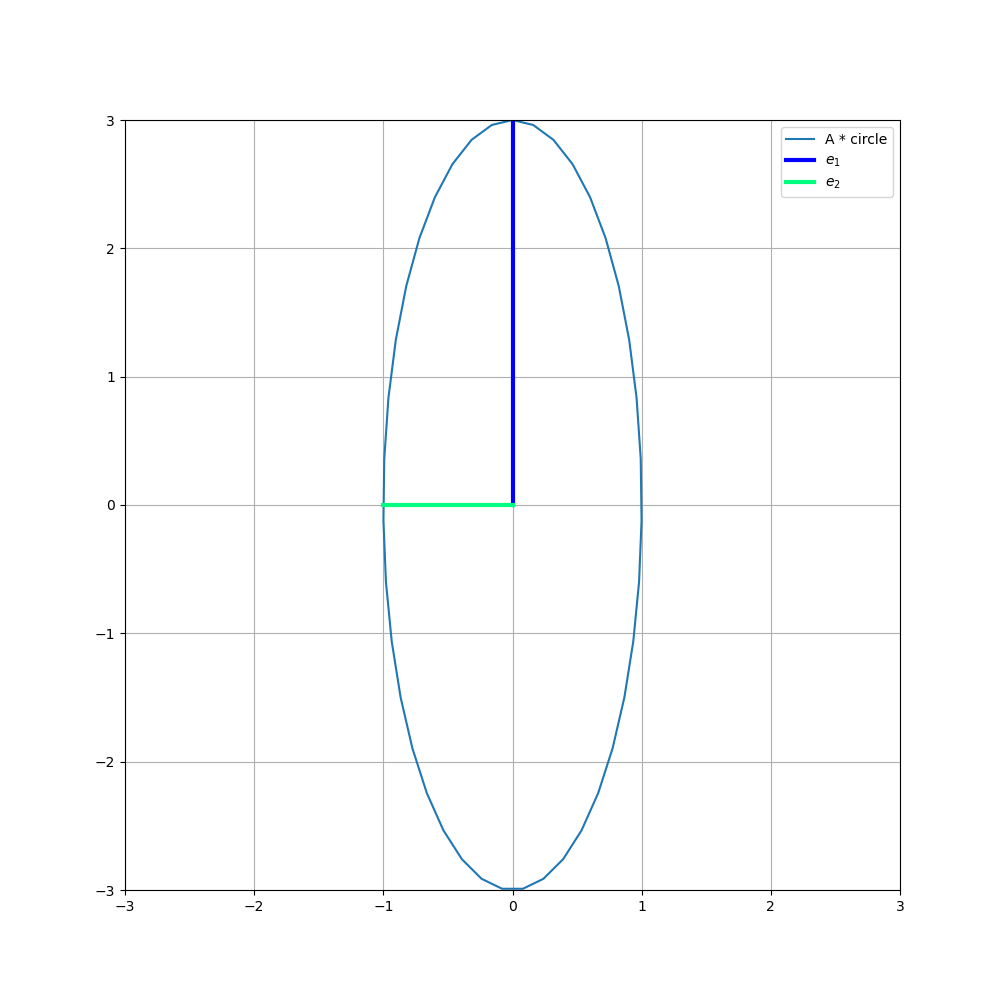

In [4]:
A2D = np.array([
    # ----- YOUR CODE HERE ----- #
    [0, -1],
    [3, 0]
])

A3D = np.array([
    [1, 2, -1],
    [1, 1, 0],
    [0, -1, 1]])

points = transform(A2D, label='A * circle')

In [5]:
U,s,VT = np.linalg.svd(A2D)
E = np.diag(s) # this only works for square matrices. Other matrices will need to pad with zeros

print(f"U: \n{U}\n")
print(f"Sigma: \n{E}\n")
print(f"V.T: \n{VT}\n")

U: 
[[ 0. -1.]
 [-1.  0.]]

Sigma: 
[[3. 0.]
 [0. 1.]]

V.T: 
[[-1. -0.]
 [ 0.  1.]]



In [23]:
transform(VT, label=r"$V^\top Circle$")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [24]:
transform(E, label='E*circle')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [25]:
transform(E@VT, label=r"$EV^\top$ circle")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [26]:
transform(U, label="U circle")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [27]:
transform(U @ E @ VT, label=r"$UEV\top$ circle")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [28]:
transform(A2D, with_basis=False)
transform.plot_vectors((U@E).T, prefix=r"(U\Sigma)")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Contributors: 
- Neelesh Ramachandran
- Kareem Ahmad
- Kumar Krishna Agrawal
